In [1]:
import os
import warnings
import urllib
import zipfile
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.insert(0, '/home/igor.zubarev/projects/HDN-main/')

from models.lvae import LadderVAE
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from boilerplate import boilerplate
import lib.utils as utils
import training
from tifffile import imread
from scipy import ndimage
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Configure Hierarchical DivNoising Model

<code>model_name</code> specifies the name of the model with which the weights will be saved and wil be loaded later for prediction.<br>
<code>directory_path</code> specifies the directory where the model weights and the intermediate denoising and generation results will be saved. <br>
<code>noiseModel</code> specifies a noise model for training. If noisy data is generated synthetically using Gaussian noise, set it to None.<br>
<code>batch_size</code> specifies the batch size used for training. The default batch size of $16$ works well for most natural image datasets.<br>
<code>virtual_batch</code> specifies the virtual batch size used for training. It divides the <code>batch_size</code> into smaller mini-batches of size <code>virtual_batch</code>. Decrease this if batches do not fit in memory.<br>
<code>test_batch_size</code> specifies the batch size used for testing every $1000$ training steps. Decrease this if test batches do not fit in memory, it does not have any consequence on training. It is just for intermediate visual debugging.<br>
<code>lr</code> specifies the learning rate.<br>
<code>max_epochs</code> specifies the total number of training epochs. Around $150-200$ epochs work well generally.<br>
<code>steps_per_epoch</code> specifies how many steps to take per epoch of training. Around $500$ steps work well for most natural image datasets.<br>
<code>num_latents</code> specifies the number of stochastic layers. The default setting of $6$ works well for most datasets but quite good results can also be obtained with as less as $4$ layers. However, more stochastic layers may improve performance for some datasets at the cost of increased training time.<br>
<code>z_dims</code> specifies the number of bottleneck dimensions (latent space dimensions) at each stochastic layer per pixel. The default setting of $32$ works well for most datasets.<br>
<code>blocks_per_layer</code> specifies how many residual blocks to use per stochastic layer. Usually, setting it to be $4$ or more works well. However, more residual blocks improve performance at the cost of increased training time.<br>
<code>batchnorm</code> specifies if batch normalization is used or not. Turning it to True is recommended.<br>
<code>free_bits</code> specifies the threshold below which KL loss is not optimized for. This prevents the [KL-collapse problem](https://arxiv.org/pdf/1511.06349.pdf%3Futm_campaign%3DRevue%2520newsletter%26utm_medium%3DNewsletter%26utm_source%3Drevue). The default setting of $1.0$ works well for most datasets.<br>

**__Note:__** With these settings, training will take approximately $12$ hours on Tesla P100/Titan Xp GPU needing less than 6 GB GPU memory. We optimized the code to run on less GPU memory. For faster training, consider increasing ```virtual_batch_size``` but since we have not tested with different settings of ```virtual_batch_size```, we do not yet know how this affects results. To reduce traing time, also consider reducing either ```num_latents``` or ```blocks_per_layer``` to $4$. These settings will bring down the training time even more.

In [3]:
### We extract overlapping patches of size ```patch_size x patch_size``` from training and validation images.
### Usually 128x128 patches work well for most natural image datasets
patch_size = 64

gaussian_noise_std = None


model_name = "mouse"
directory_path = "./Trained_model/"
load_checkpoint = False
noiseModel = None

# Training-specific
batch_size = 4
virtual_batch = batch_size
lr = 3e-4
max_epochs = 30
steps_per_epoch = 500
test_batch_size = 8 #Assert > num images to save test

# Model-specific
num_latents = 5
z_dims = [32]*int(num_latents)
blocks_per_layer = 4
batchnorm = True
free_bits = 1.0

In [4]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

link = 'https://download.fht.org/jug/denoiseg/Mouse-Organoid-Cells-CBG-128_n20.zip'

# check if data has been downloaded already
zipPath = 'data/Mouse-Organoid-Cells-CBG-128_n20.zip'
if not os.path.exists(zipPath):
    data = urllib.request.urlretrieve(link, zipPath)

#unzip the files
if not os.path.exists(zipPath[:-4]):
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall('data')

In [7]:
train = np.load(os.path.join(zipPath[:-8], 'train_data_n20.npz'))
val = np.load(os.path.join(zipPath[:-8], 'test_data_n20.npz'))

c = 40
X = train['X_train'][:c, ...].astype(np.float32)
val = val['X_test'][:c, ...].astype(np.float32)

print("Shape of Train volume:      {}".format(X.shape))
print("Shape of Validation volume: {}".format(val.shape))


Shape of Train volume:      (40, 32, 128, 128)
Shape of Train mask:        (40, 32, 128, 128)
Shape of Validation volume: (22, 32, 128, 128)
Shape of Validation mask:   (22, 32, 128, 128)


In [8]:
!{sys.executable} -m pip install itkwidgets

In [10]:
from itkwidgets import view, compare


view(X)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

# 3D visualization[optional]

#### For 3D visualization to be representative we resize the volume according to dataset's voxel(ZYX) size of [1.0, 0.1733, 0.1733] um. You may want to adjust the brighness level

In [11]:
# Here we resize the volume for visualization purposes

# X_resized_3d = ndimage.zoom(d[:, :, :480], (1.9, 1, 1), order=0)
# print(X_resized_3d.shape)
# view(X_resized_3d)

In [10]:
from skimage.util import view_as_windows

#TODO Add dataloader
split_windows_train = view_as_windows(X[:, :, :], (1, 32, 64, 64), (1, 12, 12, 12)).squeeze().reshape((-1, 32, 64, 64))
split_windows_val = view_as_windows(val[:, :, :], (1, 32, 64, 64), (1, 12, 12, 12)).squeeze().reshape((-1, 32, 64, 64))

img_shape = (split_windows_train.shape[1], split_windows_train.shape[2], split_windows_train.shape[3])

print("Shape of Train tiles:      {}".format(split_windows_train.shape))
print("Shape of Validation tiles: {}".format(split_windows_val.shape))


(1440, 32, 64, 64)


Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

# Train Hierarchical DivNoising Model

In [ ]:
train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(split_windows_train,
                                                                                           split_windows_val,
                                                                                           split_windows_val,
                                                                                           batch_size,
                                                                                           test_batch_size)

if load_checkpoint:
    model = torch.load("./Trained_model/model/mouse_last_vae.net")
else:
    model = LadderVAE(
        z_dims=z_dims,
        blocks_per_layer=blocks_per_layer,
        data_mean=data_mean,
        data_std=data_std,
        noiseModel=noiseModel,
        conv_mult=3,
        device=device,
        batchnorm=batchnorm,
        free_bits=free_bits,
        img_shape=img_shape,
        grad_checkpoint=True
        ).cuda()


In [13]:
model.train() # Model set in training mode

training.train_network(
    model=model,                       
    lr=lr,
    max_epochs=max_epochs,
    steps_per_epoch=steps_per_epoch,
    test_log_every=500,
    directory_path=directory_path,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    virtual_batch=virtual_batch,
    gaussian_noise_std=gaussian_noise_std,
    model_name=model_name,
    nrows=2,
    gradient_scale=8192
    )



Starting epoch 0


 13%|█▎        | 44/350 [00:28<02:32,  2.00it/s]

# Plotting Losses

In [16]:
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

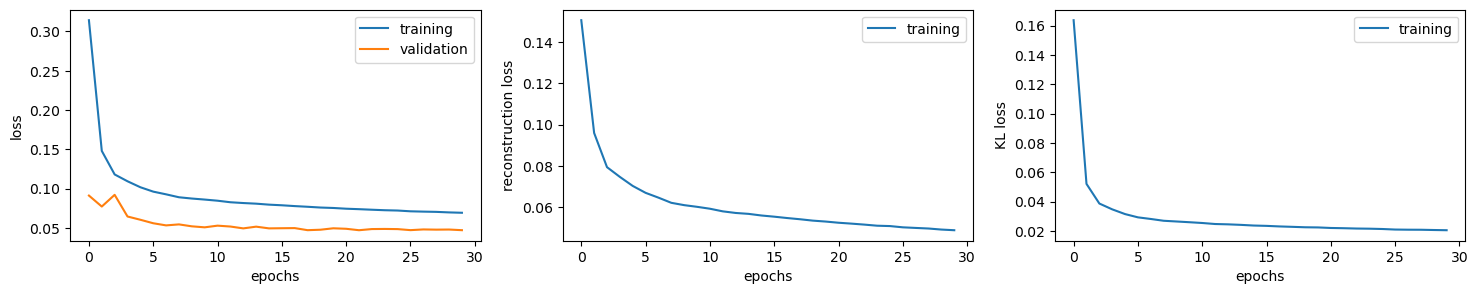

In [17]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()